   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


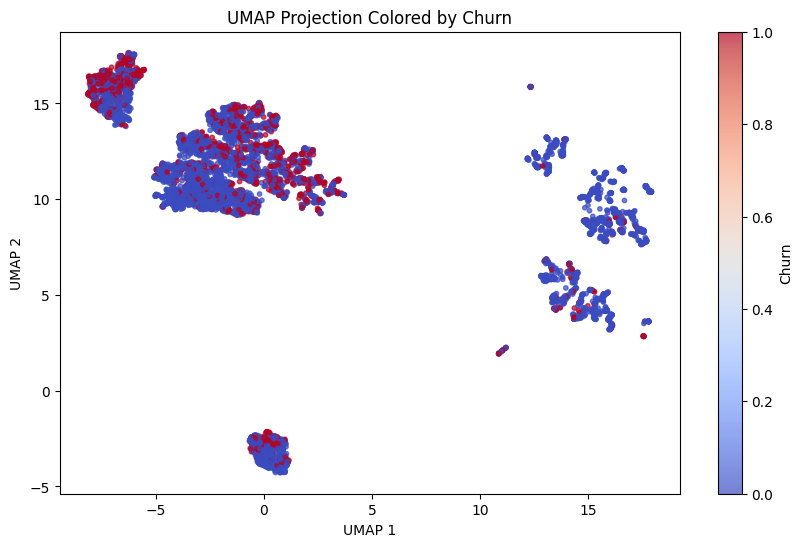

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import umap
from scipy.stats import entropy

# === 1. Load and preview data ===
df = pd.read_csv("telco_churn.csv")
print(df.head())
print(df.info())

# === 2. Clean and encode ===
# Drop customerID if it's there
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# Encode target (Churn)
target_col = 'Churn'
df[target_col] = df[target_col].map({'Yes': 1, 'No': 0})

# Identify categorical and numerical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Fill missing values if any
df[cat_cols] = df[cat_cols].fillna('Unknown')
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Encode categorical features
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separate target
y = df[target_col]
X = df.drop(columns=[target_col])

# === 3. Compute per-row Shannon entropy ===
def row_entropy(row):
    probs = row.value_counts(normalize=True)
    return entropy(probs, base=2)

entropy_feature = X.apply(row_entropy, axis=1)
X['ShannonEntropy'] = entropy_feature

# === 4. Normalize ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 5. Run UMAP ===
reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_scaled)

# === 6. Plot UMAP with Churn ===
plt.figure(figsize=(10, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.7)
plt.title("UMAP Projection Colored by Churn")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Churn")
plt.show()


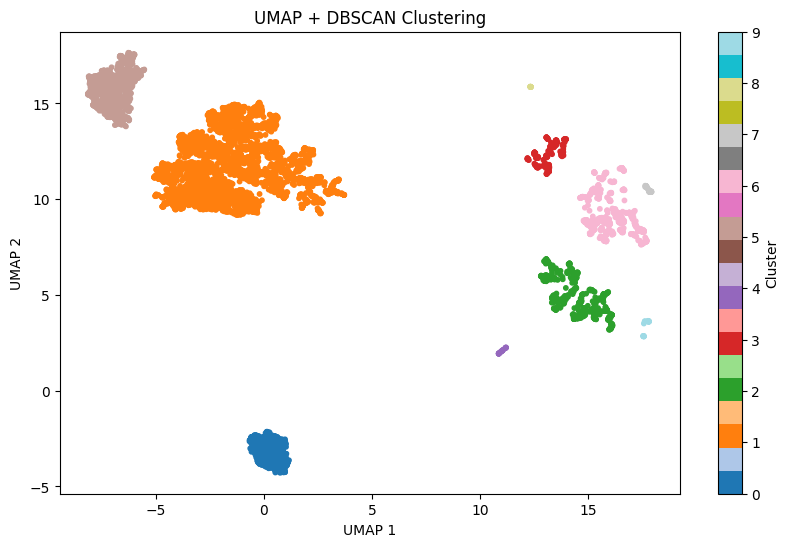

C:\Users\bobov\AppData\Local\Temp\ipykernel_21972\2699059729.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_cluster.index, y=churn_by_cluster['ChurnRate'], palette='coolwarm')


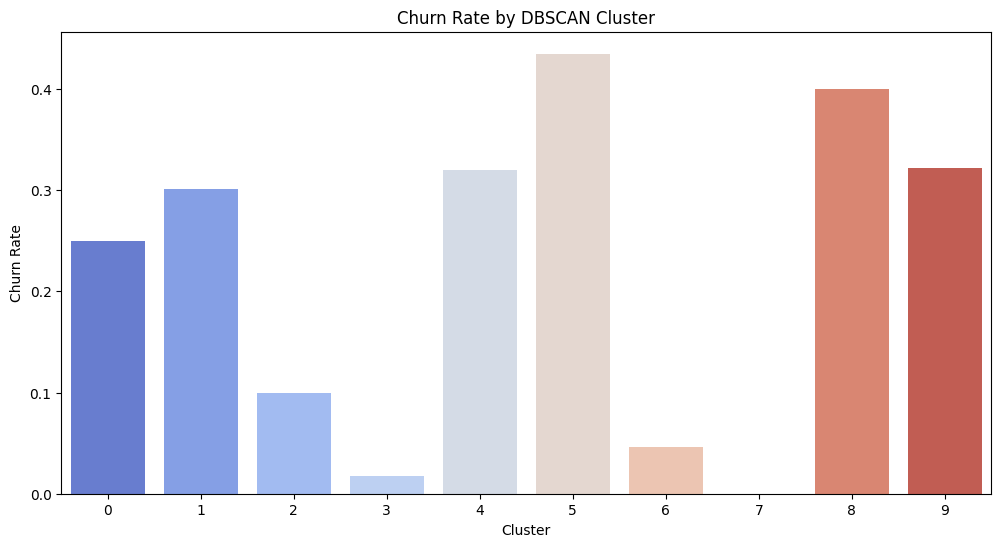

In [22]:
from sklearn.cluster import DBSCAN

# === 7. Run DBSCAN on UMAP space ===
dbscan = DBSCAN(eps=0.8, min_samples=10)  # you can tune these
cluster_labels = dbscan.fit_predict(X_umap)

# Add to DataFrame
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['Churn'] = y.values
df_umap['Cluster'] = cluster_labels

# === 8. Plot DBSCAN Clusters ===
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=df_umap['Cluster'], cmap='tab20', s=10)
plt.title("UMAP + DBSCAN Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(scatter, label="Cluster")
plt.show()

# === 9. Churn rate per cluster ===
churn_by_cluster = df_umap.groupby('Cluster')['Churn'].agg(['count', 'sum', 'mean'])
churn_by_cluster.rename(columns={'sum': 'ChurnCount', 'mean': 'ChurnRate'}, inplace=True)

import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(x=churn_by_cluster.index, y=churn_by_cluster['ChurnRate'], palette='coolwarm')
plt.title("Churn Rate by DBSCAN Cluster")
plt.xlabel("Cluster")
plt.ylabel("Churn Rate")
plt.show()


In [24]:
# Merge cluster labels back into original df for profiling
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

# Example: look at means of features in high-churn clusters
high_churn_clusters = churn_by_cluster[churn_by_cluster['ChurnRate'] > 0.35].index.tolist()
cluster_profiles = df_clustered[df_clustered['Cluster'].isin(high_churn_clusters)].groupby('Cluster').mean()

sample_customers = df_clustered[df_clustered['Cluster'].isin(high_churn_clusters)].sample(5)
print(sample_customers)



      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
5476       0              1        0           0       5             1   
4936       0              1        0           0      45             1   
6625       0              1        0           0      12             1   
6368       1              1        0           0       2             1   
3642       0              1        0           0      30             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  ...  \
5476              0                1               0             0  ...   
4936              2                1               2             2  ...   
6625              2                1               0             2  ...   
6368              2                1               0             0  ...   
3642              2                1               0             2  ...   

      TechSupport  StreamingTV  StreamingMovies  Contract  PaperlessBilling  \
5476            0        

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X_new = df_umap[['UMAP1', 'UMAP2']].copy()
X_new['Entropy'] = entropy_feature.values
X_new['Cluster'] = cluster_labels
churn_model = RandomForestClassifier(random_state=42)
scores = cross_val_score(churn_model, X_new, y, cv=5)
print("Churn Prediction Accuracy with UMAP+Entropy+Cluster:", scores.mean())


Churn Prediction Accuracy with UMAP+Entropy+Cluster: 0.741446524775792


In [26]:
from sklearn.model_selection import train_test_split

X_orig_train, X_orig_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_orig_train, y_train)
print("Baseline accuracy:", clf.score(X_orig_test, y_test))


Baseline accuracy: 0.7984386089425124


C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\bobov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


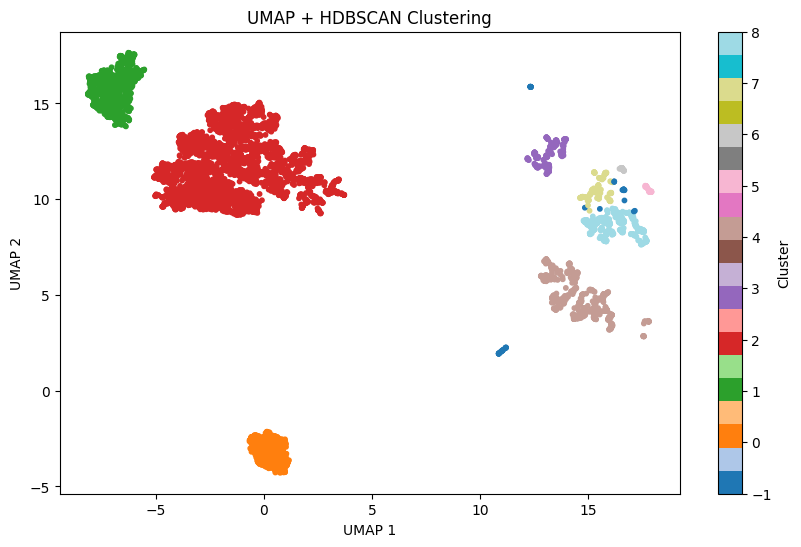

In [27]:
import hdbscan

# === 1. Run HDBSCAN on UMAP-reduced data ===
hdb = hdbscan.HDBSCAN(min_cluster_size=30, prediction_data=True)
hdb_labels = hdb.fit_predict(X_umap)

# Optional: Probabilities of cluster membership
membership_strengths = hdb.probabilities_

# Add to DataFrame
df_umap['HDBSCAN_Cluster'] = hdb_labels
df_umap['MembershipStrength'] = membership_strengths

# === 2. Visualize HDBSCAN clustering ===
plt.figure(figsize=(10, 6))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=hdb_labels, cmap='tab20', s=10)
plt.title("UMAP + HDBSCAN Clustering")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label="Cluster")
plt.show()


C:\Users\bobov\AppData\Local\Temp\ipykernel_21972\2570203218.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_hdb.index, y=churn_hdb['ChurnRate'], palette='coolwarm')


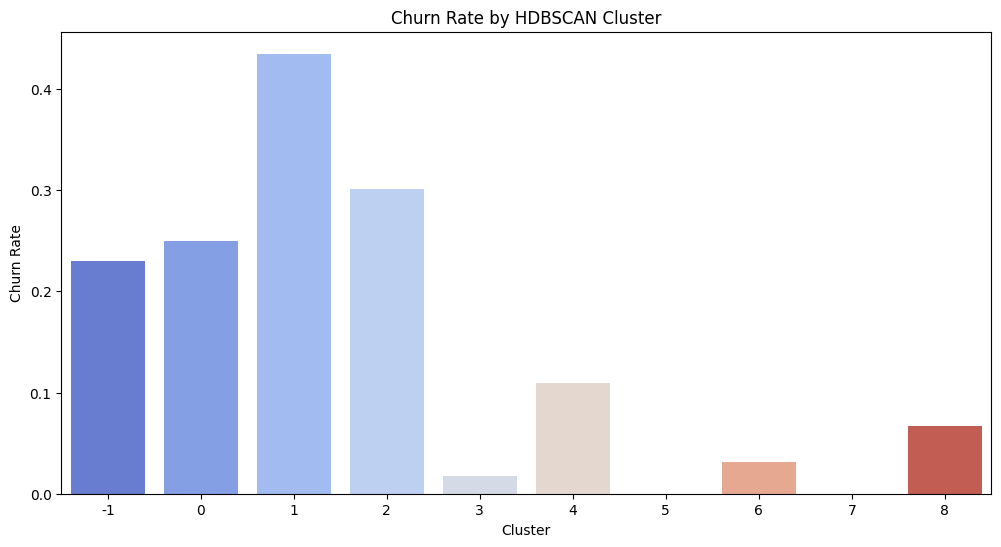

In [28]:
# Similar to before, but now using HDBSCAN clusters
churn_hdb = df_umap.groupby('HDBSCAN_Cluster')['Churn'].agg(['count', 'sum', 'mean'])
churn_hdb.rename(columns={'sum': 'ChurnCount', 'mean': 'ChurnRate'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(x=churn_hdb.index, y=churn_hdb['ChurnRate'], palette='coolwarm')
plt.title("Churn Rate by HDBSCAN Cluster")
plt.xlabel("Cluster")
plt.ylabel("Churn Rate")
plt.show()


In [29]:
X_hdb = df_umap[['UMAP1', 'UMAP2', 'MembershipStrength']].copy()
X_hdb['HDBSCAN_Cluster'] = hdb_labels

# Replace -1 (noise) with a separate value or NaN
X_hdb['HDBSCAN_Cluster'] = X_hdb['HDBSCAN_Cluster'].replace(-1, np.nan)

# Fill NaNs if needed
X_hdb = X_hdb.fillna(-1)

# Train model
scores_hdb = cross_val_score(RandomForestClassifier(random_state=42), X_hdb, y, cv=5)
print("Accuracy with HDBSCAN features:", scores_hdb.mean())


Accuracy with HDBSCAN features: 0.7371851611394283


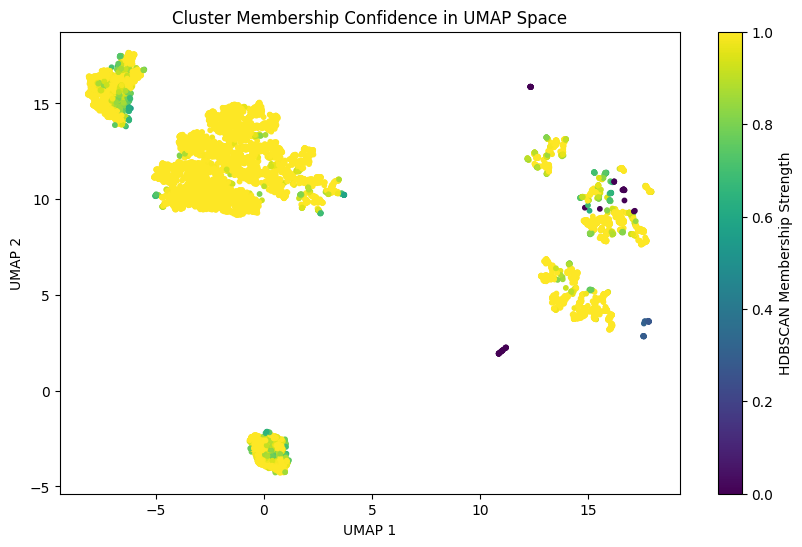

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'],
            c=df_umap['MembershipStrength'],
            cmap='viridis', s=10)
plt.colorbar(label="HDBSCAN Membership Strength")
plt.title("Cluster Membership Confidence in UMAP Space")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


In [31]:
# Normalize entropy to [0, 1]
entropy_norm = (entropy_feature - entropy_feature.min()) / (entropy_feature.max() - entropy_feature.min())

# Use churn rate by HDBSCAN cluster
df_umap['Entropy'] = entropy_norm
df_umap['ChurnRateInCluster'] = df_umap['HDBSCAN_Cluster'].map(churn_hdb['ChurnRate'])

# Combine: high entropy + low membership strength + high churn rate
df_umap['ChurnRiskScore'] = (
    df_umap['Entropy'] * 0.4 +
    (1 - df_umap['MembershipStrength']) * 0.3 +
    df_umap['ChurnRateInCluster'].fillna(0) * 0.3
)


In [32]:
# Sort by churn risk score (descending = riskier)
df_umap_sorted = df_umap.sort_values(by='ChurnRiskScore', ascending=False)

# Flag top 5% as "HighRisk"
top_5_percent = int(0.05 * len(df_umap_sorted))
df_umap_sorted['HighRisk'] = 0
df_umap_sorted.iloc[:top_5_percent, df_umap_sorted.columns.get_loc('HighRisk')] = 1


In [34]:
# Align HighRisk back with original X rows
df_high_risk = df_umap_sorted[['HighRisk']]
df_high_risk.index = X.index  # make sure indices match

# Define X and y
y_risk = df_high_risk['HighRisk']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_risk, test_size=0.2, random_state=42)

# Train model
clf_risk = RandomForestClassifier(random_state=42)
clf_risk.fit(X_train, y_train)
print("HighRisk prediction accuracy:", clf_risk.score(X_test, y_test))


HighRisk prediction accuracy: 0.9396735273243435


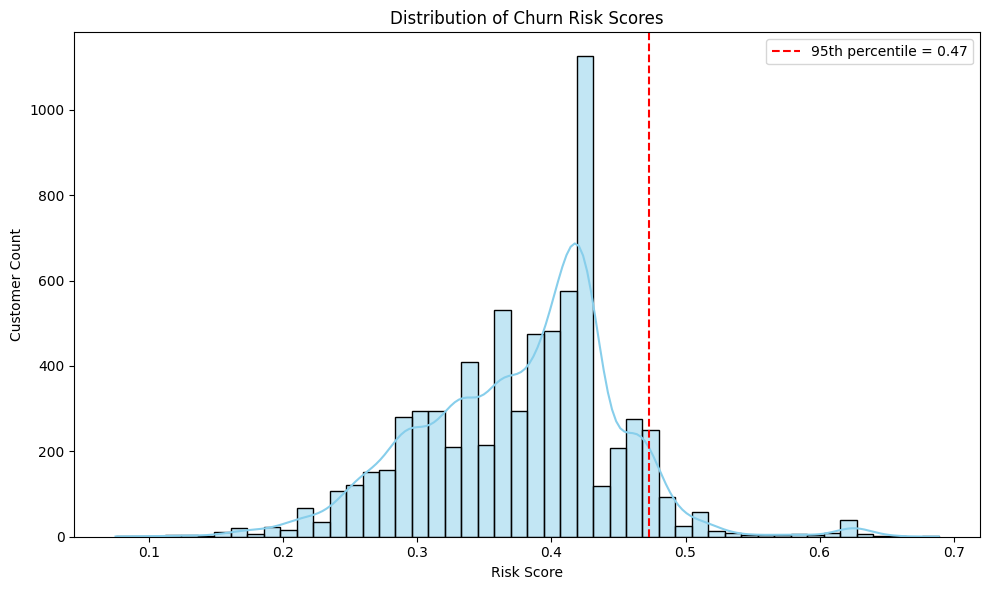

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume df contains your risk score
risk_scores = df_umap["ChurnRiskScore"]
threshold = risk_scores.quantile(0.95)

plt.figure(figsize=(10, 6))
sns.histplot(risk_scores, bins=50, kde=True, color="skyblue", edgecolor="black")
plt.axvline(threshold, color='red', linestyle='--', label=f'95th percentile = {threshold:.2f}')
plt.title("Distribution of Churn Risk Scores")
plt.xlabel("Risk Score")
plt.ylabel("Customer Count")
plt.legend()
plt.tight_layout()
plt.savefig("images/churn_risk_score_distribution.png")
plt.show()

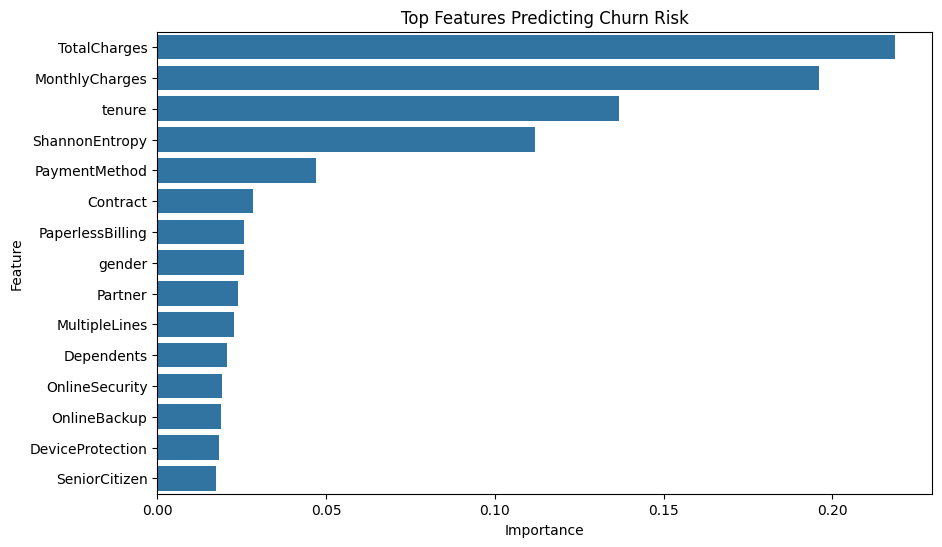

In [38]:
importances = clf_risk.feature_importances_
feat_names = X.columns

feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x='Importance', y='Feature')
plt.title("Top Features Predicting Churn Risk")
plt.show()


In [39]:
# Recompute HighRisk flag in-place (top 5% by churn risk score)
threshold = df_umap['ChurnRiskScore'].quantile(0.95)
df_umap['HighRisk'] = (df_umap['ChurnRiskScore'] >= threshold).astype(int)


In [40]:
# Start from the cleaned/encoded feature set
export_df = X.copy()

# Add label
export_df['Churn'] = y.values

# Add entropy
export_df['ShannonEntropy'] = entropy_feature.values

# Add UMAP
export_df['UMAP1'] = df_umap['UMAP1'].values
export_df['UMAP2'] = df_umap['UMAP2'].values

# Add DBSCAN cluster
if 'Cluster' in df_umap.columns:
    export_df['DBSCAN_Cluster'] = df_umap['Cluster'].values

# Add HDBSCAN info
export_df['HDBSCAN_Cluster'] = df_umap['HDBSCAN_Cluster'].values
export_df['MembershipStrength'] = df_umap['MembershipStrength'].values

# Add churn risk metrics
export_df['ChurnRateInCluster'] = df_umap['ChurnRateInCluster'].values
export_df['ChurnRiskScore'] = df_umap['ChurnRiskScore'].values
export_df['HighRisk'] = df_umap['HighRisk'].values

# Export to CSV
export_df.to_csv("churn_dashboard_data.csv", index=False)
print("Exported to churn_dashboard_data.csv")


Exported to churn_dashboard_data.csv
